In [2]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator
from trace_IO import *
from OptimumFilter import *

import matplotlib.pyplot as plt

def plot_trace_set(trace_set, offset=50):
    """
    Plot a single trace set (shape: 54 x N) with vertical offsets.

    Parameters:
    - trace_set: ndarray, shape (54, N)
    - offset: float, vertical offset between channels
    """
    n_channels, n_samples = trace_set.shape

    for i in range(n_channels):
        color = 'r' if i > 44 else 'b'
        plt.plot(np.arange(n_samples), trace_set[i] + i * offset, color=color, lw=0.2)

    plt.xlabel("Sample Index")
    plt.yticks([])
    plt.ylim(-10, offset * n_channels)
    plt.title("Trace Set")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('../archive/config.yaml')
ts = TraceSimulator(config)

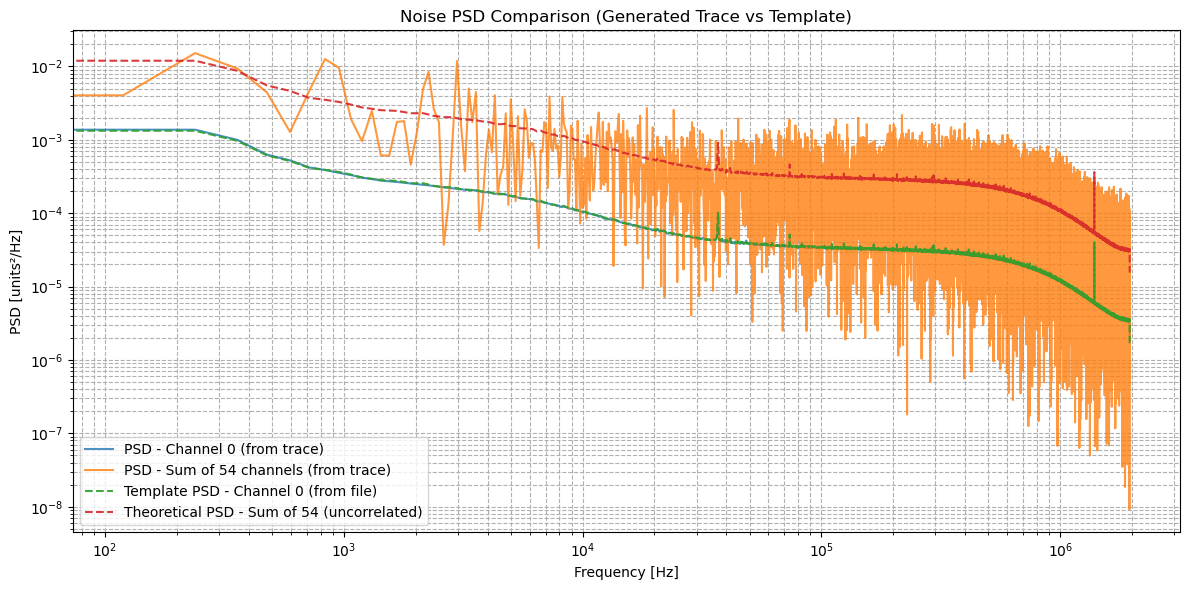

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq

# -------------------------
# 1. Generate Noise Trace
# -------------------------
trace = ts.generate(
    E=0, x=-40, y=80, z=-1800,
    no_noise=False, type_recoil='ER',
    quantize=False, phonon_only=False
)  # shape: (1, 54, 32768)

trace_noise = trace[0]  # shape: (54, 32768)

# -------------------------
# 2. PSD Calculation Function
# -------------------------
def calculate_psd(traces, sampling_frequency=1.0):
    norm = sampling_frequency * traces.shape[-1]
    if len(traces.shape) == 1:
        psd = (np.abs(rfft(traces)) ** 2.0) / norm
    else:
        psd = np.mean(np.abs(rfft(traces)) ** 2.0, axis=0) / norm
    psd[1:traces.shape[-1]//2 + 1 - (traces.shape[-1] + 1) % 2] *= 2.0
    f = rfftfreq(traces.shape[-1], d=1.0 / sampling_frequency)
    return f, psd

# -------------------------
# 3. Load Template PSD (Shape = 16385)
# -------------------------
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
assert noise_psd.shape == (16385,), "Expected shape (16385,) for noise_psd"

# -------------------------
# 4. Compute PSDs
# -------------------------
fs = 3906250  # 3.90625 MHz sampling frequency

f, psd_ch0 = calculate_psd(trace_noise[0], sampling_frequency=fs)
_, psd_sum = calculate_psd(np.sum(trace_noise[45:], axis=0), sampling_frequency=fs)
psd_theoretical_sum = 9 * noise_psd  # Assuming uncorrelated noise

# -------------------------
# 5. Plotting
# -------------------------
plt.figure(figsize=(12, 6))
plt.loglog(f, psd_ch0, label='PSD - Channel 0 (from trace)', alpha=0.8)
plt.loglog(f, psd_sum, label='PSD - Sum of 54 channels (from trace)', alpha=0.8)
plt.loglog(f, noise_psd, '--', label='Template PSD - Channel 0 (from file)', alpha=0.9)
plt.loglog(f, psd_theoretical_sum, '--', label='Theoretical PSD - Sum of 54 (uncorrelated)', alpha=0.9)

plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [units²/Hz]')
plt.title('Noise PSD Comparison (Generated Trace vs Template)')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()


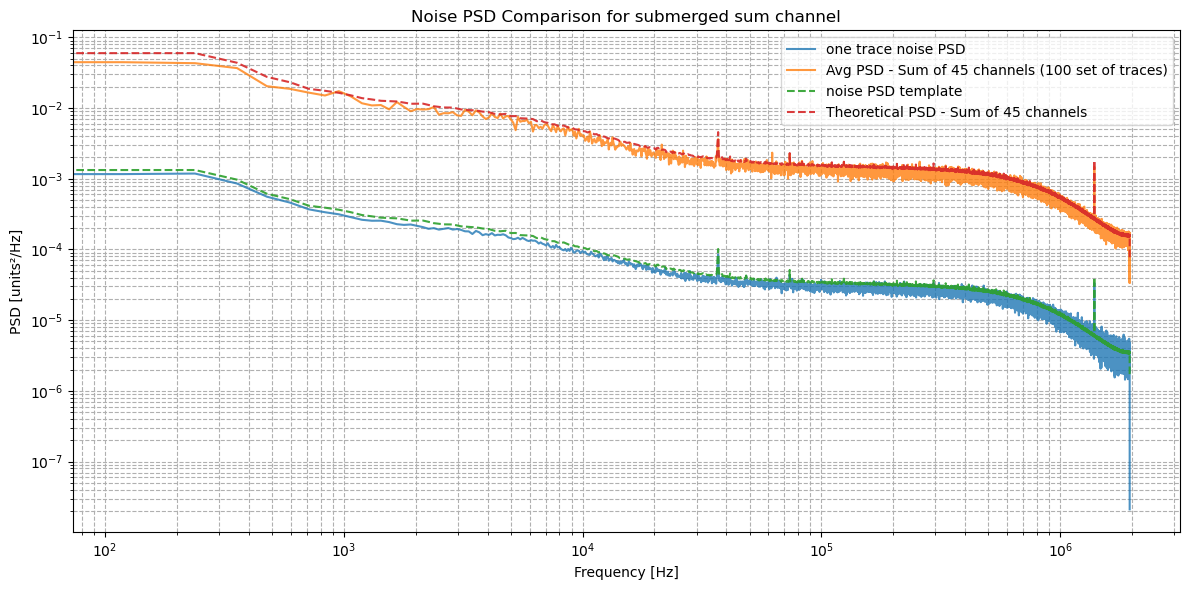

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq

# -------------------------
# 1. Generate 100 Noise Traces
# -------------------------
num_traces = 100
channel_subset = 45

all_traces = np.array([
    ts.generate(E=0, x=-40, y=80, z=-1800, no_noise=False, type_recoil='ER',
                quantize=True, phonon_only=False)[0][:channel_subset]
    for _ in range(num_traces)
])  # shape: (100, 45, 32768)

# -------------------------
# 2. PSD Calculation Function
# -------------------------
def calculate_psd(traces, sampling_frequency=1.0):
    norm = sampling_frequency * traces.shape[-1]
    if len(traces.shape) == 1:
        psd = (np.abs(rfft(traces)) ** 2.0) / norm
    else:
        psd = np.mean(np.abs(rfft(traces)) ** 2.0, axis=0) / norm
    psd[1:traces.shape[-1]//2 + 1 - (traces.shape[-1] + 1) % 2] *= 2.0
    f = rfftfreq(traces.shape[-1], d=1.0 / sampling_frequency)
    return f, psd

# -------------------------
# 3. Load Template PSD (Shape = 16385)
# -------------------------
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")
assert noise_psd.shape == (16385,), "Expected shape (16385,) for noise_psd"

# -------------------------
# 4. Compute PSDs
# -------------------------
fs = 3906250  # 3.90625 MHz

# Single trace from first channel of first sample
f, psd_ch0 = calculate_psd(all_traces[0, 0], sampling_frequency=fs)

# Sum first 45 channels for each trace → shape: (100, 32768)
sum_signals = np.sum(all_traces, axis=1)

# Compute PSD for each summed signal
psds = np.array([
    calculate_psd(trace, sampling_frequency=fs)[1] for trace in sum_signals
])  # shape: (100, 16385)

# Average PSD across 100 summed traces
psd_sum_avg = np.mean(psds, axis=0)

# Theoretical PSD assuming uncorrelated noise summed over 45 channels
psd_theoretical_sum = channel_subset * noise_psd

# -------------------------
# 5. Plotting
# -------------------------
plt.figure(figsize=(12, 6))
plt.loglog(f, psd_ch0, label='one trace noise PSD', alpha=0.8)
plt.loglog(f, psd_sum_avg, label='Avg PSD - Sum of 45 channels (100 set of traces)', alpha=0.8)
plt.loglog(f, noise_psd, '--', label='noise PSD template', alpha=0.9)
plt.loglog(f, psd_theoretical_sum, '--', label='Theoretical PSD - Sum of 45 channels', alpha=0.9)

plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [units²/Hz]')
plt.title('Noise PSD Comparison for submerged sum channel')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()


In [7]:
import numpy as np

# Load the single-channel noise PSD
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")  # shape (16385,)
assert noise_psd.shape == (16385,), "Expected shape (16385,) for noise_psd"

# Number of uncorrelated channels
channel_subset = 45

# Compute theoretical summed PSD
psd_theoretical_sum = channel_subset * noise_psd

# Save to file
output_path = "../templates/sum_ch/noise_psd_from_MMC_sum45.npy"
np.save(output_path, psd_theoretical_sum)

print(f"Theoretical 45-channel PSD saved to: {output_path}")


Theoretical 45-channel PSD saved to: ../templates/sum_ch/noise_psd_from_MMC_sum45.npy
